Manga (漫画 Manga) are comics created in Japan, or by creators in the Japanese language, conforming to a style developed in Japan in the late 19th century.[1] They have a long and complex pre-history in earlier Japanese art.

Manga stories are typically printed in black-and-white,[9] although some full-color manga exist (e.g., Colorful). Colorization of Manga is usually done after it is released in black and white format. This is often avoided because colorization is time-consuming.

To this point, the goal of this project is to aleviate this time consuming pain of colorization by using machine learning to train a model which will thereby be able to perform automatic colorization. It will train on colorized examples to identify shapes and objects in the manga image which are a consistent color. Then, when fed a black and white manga from the same artist and series, it should be able to guess the fill color by relating the properties of the shape to the training set. The same artist and series is chosen to simlify this procedure. Generalization may be part of expansion of this project if it goes well :). 

Now, what manga will we use? What a silly question! One Piece of Course! The inspiring story of a boy who eats the Gomu Gomu no mi (rubber fruit) and is going to be the Pirate King one day! If you haven't read this epic tale, not only will you get a fun glimpse of it while reading through this notebook, but I highly suggest you read the rest.

![title](img/OPtitle.jpg)

The advantages of choosing one piece are as follows: 

1. First and most importantly, its awesome. This will make it a blast to "examine the data" so to speak. 
2. Second, there are 800 mangas chapters out so far! At an estimated 6000 polygons per page and 20 pages per chapter, this amounts to 96,000,000 example polyons! More than enough data to train on, and we will most likely only choose a small subset of this to train on, but we can always get more. All one piece chapters are available in many different places online
3. Luffy is only 1/2 of the way through the grand line, so there is tons more manga to come. That means, that unlike complete series such as naruto which have been colorized in full already, utility may come out of the output model from this project for years to come!

Prior art. 

There have been a number of previous attempts to do this, divided into 2 categories: 

1. Manga is often auto-colored via this technique. A section is manually colored and a "bucket fill algorithm is used
2. Machine learning auto-colorization techniques are often pixel based. They work on real life jpgs. 

This is an attempt to combine the two approaches. 

A critical juncture at this point is to note that this project processes and uses SVG images rather than the jpg format in which most manga is distributed on the web. As I began this project, I ran into the age old adage: data cleaning is the 80% of the work. Getting these polygons out of the bitmaps would require the use of openCV and a custom graph cut algorithm to seperate these polygons from their brethen. Largely because this is a pain in the ass, I began to look for other options. 1 that was staring me in the face, was the SVG format. In this format, each polygon is described as a path. If only there was an easy way to covert bitmaps into SVGs.... but wait! Vector Magic to the rescue. As most software developers know, why build a tool when you can use one. 

And so, the first step for preprocessing this data consists of batch-converting the jpg manga chapters into svg format via Vector Magic. 

Now, once this is done, we must select what features we are going to learn on. First, lets parse a sample svg and see what a standard path looks like.


In [5]:
from xml.dom import minidom
with open('sabody.svg','rb') as svg_file:
    doc = minidom.parse(svg_file)  # parseString also exists
    paths = [path.getAttribute('d') for path
                    in doc.getElementsByTagName('path')]
    doc.unlink()
    
print paths[0]   #look at the first path
    

 M 0.00 0.00 L 0.70 0.00 C 2.19 2.06 3.75 4.08 5.25 6.13 L 4.71 7.45 C 3.02 6.02 1.45 4.47 0.00 2.81 L 0.00 0.00 Z


Each path starts with an M (Move to), and consists of series of lines (L) or curves (C), finishing up with a Z, closing the path and returning it to its original starting point. Luckily the SVGs created with Vector Magic don't include any transformations or other SVG elements. What a tool!

Now, we want to format this data into a list of features. What features are we gonna pick?

To hazard the first guess, Im gonna say: 

1. Polygon length
2. Polygon area
3. Position in list
4. Position in chart
5. number of elements - complexity of the shape
6. distribution of lines vs Curves - how curvy is it?
7. Intensity

Thus our training data will consist of 7 features. As for the labels, for now, because the svg uses hex notation, we will use RGB values. Hex to RGB is an easy conversion and the RGB values will give some level of visual continuity between different colors - ie: (244,34,22) is close in appearance to (245,35,23). One cool aspect of this project is that the accuracy of the models predictions can be verified visually as well as by the strict numeric error/cost. Thus our labels data will consist of 3 seperate variables and we must look for models which work on multivariate problems. Finally, it is important to note that other colorization machine learning projects such as https://www.lri.fr/~gcharpia/colorization_chapter.pdf have used other color spaces like CIE-Lab because the visual continuity is closer to human color perception. Those are probably better options and may guide the eventual direction of this project. This is a first draft, remember. 

To that point, lets start with the simplest possible model - Linear Regression. We will set up the pipeline so to speak - first getting the data in a form that the model can fit and predict as well as parsing out the results so that they can be verified and evaluated. Then using those results we will switch out a few different model options into our pipeline. 

First of all, we will parse out the svg's and compute our chosen features on each path, then save each path as a seperate line in a train_features.csv file. At the same time, we will parse out the fill value for each path and save it off into a different file - train_labels.csv. At the end of this process, our files should have the same number of lines - one for each path. Finally, onto some code!


In [2]:
from xml.dom import minidom
import numpy as np
import os
from matplotlib.colors import hex2color
import csv
from svg.path import parse_path


# Building Labels file and Paths array for use below
paths = []
with open('train_labels.txt','wb') as res_file:
    for i in os.listdir('svgs'):
        directory = os.getcwd()
        fullpath = os.path.join(directory,'svgs',i)
        print fullpath
        with open(fullpath,'rb') as svg_file:
            doc = minidom.parse(svg_file)  # parseString also exists
            for path in doc.getElementsByTagName('path'):
                fill = path.getAttribute('fill')
                res_file.write(fill+'\n')
                d = path.getAttribute('d')
                paths.append(d)
            doc.unlink()

#print len(paths)

CURVE_DIVS = 50.0000000     #we could make this smaller and reduce its load approximating points along each polygon. Or larger to improve the accuracy. In this case I made it fairly small as I think approximation inaccuracies will pale in comparison to the ones introduced elsewhere

#Building Features file. Uses Paths array from above to compute values
with open('train_features.txt','wb') as f:
    writer = csv.writer(f)
    for i,path in enumerate(paths):
        P = parse_path(path)
        length = P.length()
        corners = []
        for item in xrange(int(CURVE_DIVS)):
            dist = item/CURVE_DIVS
            print dist
            each_point = P.point(dist)
            x = each_point.real
            y = each_point.imag
            corners.append((x,y))
        n = len(corners) # of corners
        area = 0.0
        print corners
        for i in range(n):
            j = (i + 1) % n
            area += corners[i][0] * corners[j][1]
            area -= corners[j][0] * corners[i][1]
        area = abs(area) / 2.0
        index = i
        complexity = len(path)
        lines = path.count('L')
        curves = path.count('C')
        rgb = hex2color("#ff0000")
        intensity =  0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
        writer.writerow([area,length,index,complexity,lines,curves,intensity])


ImportError: No module named svg.path

In [2]:
import sys
sys.executable

'/usr/bin/python'

from IPython.display import SVG, display
display(SVG(filename='/img/best_guess.svg'))

So this isn't great, but its not horrible either. You can see hints of actual orange in Nami's hair and those line on Warpols jacket are actually purple! However, overall its a lot greyer than it should be. This tells us that the regression is undergoing the classic case of ____. Between color extremes, a safe bet for the model to predict is a middle value - aka grey. So is there some way to overcome this? 

As a good first step, lets look at what kind of color profile we're dealing with here. 

In [25]:
import seaborn as sns
import pandas as pd

colors = pd.read_csv('labels/train_labels.txt',header=0,names=['r','g','b'])

sns.distplot(colors['b'], kde=False, rug=True);

sns.plt.show()

In [1]:

import seaborn as sns

# Load one of the data sets that come with seaborn
tips = sns.load_dataset("tips")

sns.jointplot("total_bill", "tip", tips, kind='reg');

/Users/alex/python/manga_learn/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/alex/python/manga_learn/venv/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


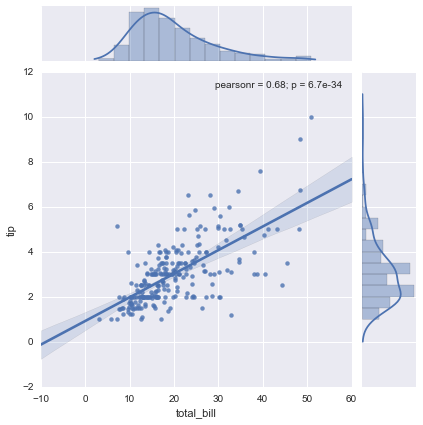

In [3]:
%matplotlib inline
import seaborn as sns

# Load one of the data sets that come with seaborn
tips = sns.load_dataset("tips")

sns.jointplot("total_bill", "tip", tips, kind='reg');
